In [6]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as Ker
import matplotlib.pyplot as plt

**I Path Simulation**

In [ ]:
import tensorflow as tf

def simulate_paths_optimized(M, T, n, r, vol, S_initial, dt):
    
    nudt = (r - 0.5 * vol**2) * dt
    lnS_initial = tf.math.log(tf.cast(S_initial, tf.float32))
    

    Z = tf.random.normal([M, n], dtype=tf.float32)
    dW = tf.sqrt(dt) * Z  
    
    delta_lnS = nudt + vol * dW  
    
    cumulative_delta_lnS = tf.math.cumsum(delta_lnS, axis=1)
    lnS_paths = cumulative_delta_lnS + lnS_initial
    lnS_paths = tf.concat([tf.fill([M, 1], lnS_initial), lnS_paths], axis=1)
    
    S = tf.exp(lnS_paths)
    return S, dW

M = 100000
T = 1.0
n = 50
dt = T/n
r = 0.06
vol = 0.2
S_initial = 36.0
K=40.0

S, dW = simulate_paths_optimized(M, T, n, r, vol, S_initial, dt)
print("Simulated asset paths shape:", S.shape)


Simulated asset paths shape: (100000, 51)


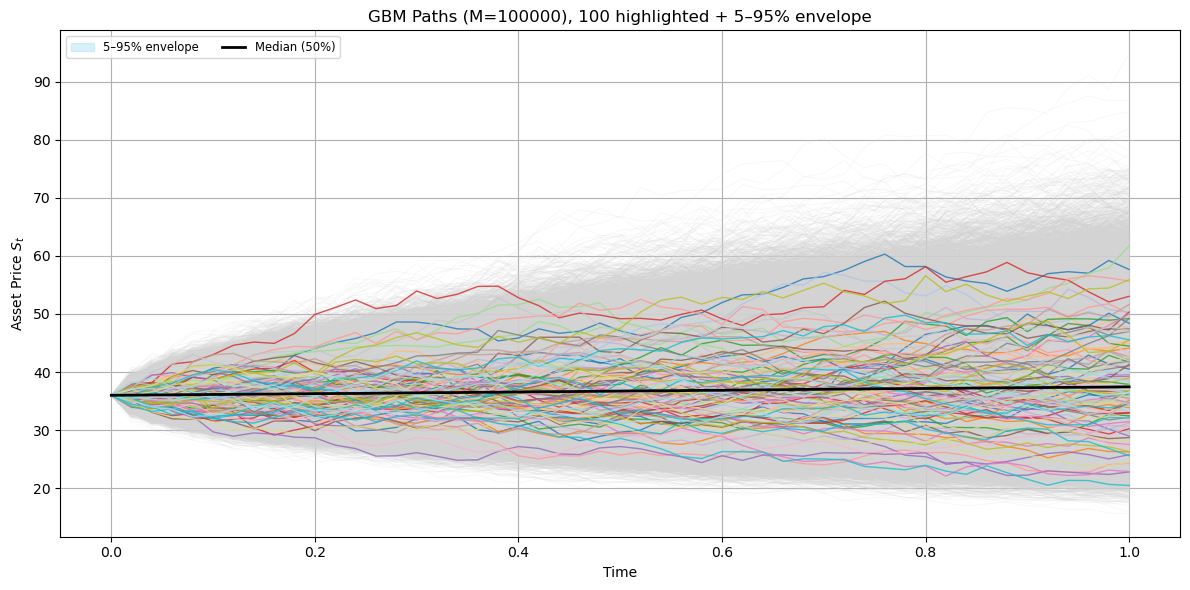

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


M, n1 = S.shape
time_grid = np.linspace(0, T, n1)

# Envelope: 5% and 95% quantiles
q05 = np.quantile(S, 0.05, axis=0)
q95 = np.quantile(S, 0.95, axis=0)
med = np.quantile(S, 0.50, axis=0)

# Plot everything
plt.figure(figsize=(12,6))

# envelope
plt.fill_between(time_grid, q05, q95,
                 color='skyblue', alpha=0.3,
                 label='5–95% envelope')


plt.plot(time_grid, S.T,
         color='lightgray', linewidth=0.5, alpha=0.2)


np.random.seed(0)
idx100 = np.random.choice(M, size=100, replace=False)
cmap = plt.get_cmap('tab20', 100)   
for j,i in enumerate(idx100):
    plt.plot(time_grid, S[i,:],
             color=cmap(j), linewidth=1,
             alpha=0.8)


plt.plot(time_grid, med,
         color='black', linewidth=2,
         label='Median (50%)')

plt.title(f'GBM Paths (M={M}), 100 highlighted + 5–95% envelope')
plt.xlabel('Time')
plt.ylabel('Asset Price $S_t$')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
def payoff(S, K):
    return tf.maximum(K - S, tf.constant(0.0, dtype=tf.float32))


In [10]:
X = tf.Variable(tf.zeros([M, n+1], dtype=tf.float32))
Y = tf.Variable(tf.zeros([M, n+1], dtype=tf.float32))
X_last_col = payoff(S[:, n], K)
X[:, n].assign(X_last_col)
Y[:, n].assign(X_last_col)
beta_dt = tf.exp(-r * dt)

**II Model Training**

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

# For Euler: num_outputs = 2 (φ, ψ)
# For Milstein: num_outputs = 3 (φ, ψ₁, ψ₂)
# For cubic variant: num_outputs = 4 (φ, ψ₁, ψ₂, ψ₃)
num_outputs = 4  # Change this value as desired

with tf.device('/GPU:0'):
    inputs = tf.keras.Input(shape=(1,))
    
    x = layers.Dense(100, activation="relu")(inputs)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)

    outputs = layers.Dense(num_outputs)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="multi_scheme_model")
    model.summary()

    # loss function.
    # For Euler (num_outputs=2), only the first term is used.
    # For Milstein (num_outputs=3), use: φ + ψ₁*dW + ψ₂*(dW^2 - dt)
    # For cubic (num_outputs=4), add: ψ₃*(dW^3 - 3*dt*dW)
    def custom_loss(y_true, y_pred):
        Y_true = y_true[:, 0]
        dW_true = y_true[:, 1]
        if num_outputs == 2:
            # Euler scheme
            prediction = y_pred[:, 0] + y_pred[:, 1] * dW_true
        elif num_outputs == 3:
            # Milstein scheme: second term = (dW^2 - dt)
            prediction = y_pred[:, 0] + y_pred[:, 1] * dW_true + y_pred[:, 2] * (tf.square(dW_true) - dt)
        elif num_outputs == 4:
            # Extended (cubic) scheme: third-order term = dW^3 - 3*dt*dW
            prediction = (y_pred[:, 0] +
                          y_pred[:, 1] * dW_true +
                          y_pred[:, 2] * (tf.square(dW_true) - dt) +
                          y_pred[:, 3] * (tf.pow(dW_true, 3) - 3 * dt * dW_true))
        else:
            raise ValueError("Unsupported number of outputs")
        return tf.reduce_mean(tf.square(Y_true - prediction))
    
    model.compile(optimizer='adam', loss=custom_loss)


Model: "multi_scheme_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,004 (160.17 KB)

 Trainable params: 41,004 (160.17 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    new_model.compile(optimizer=model.optimizer, loss=model.loss)
    new_model.set_weights(model.get_weights())
    return new_model
@tf.keras.utils.register_keras_serializable(package="Custom", name="custom_loss")

def custom_loss(y_true, y_pred):
    Y_true = y_true[:, 0]
    dW_true = y_true[:, 1]
    prediction = y_pred[:, 0] + y_pred[:, 1] * dW_true + y_pred[:, 2] * (tf.square(dW_true) - dt)
    return tf.reduce_mean(tf.square(Y_true - prediction))


In [ ]:
scheme = 'milstein'  

if scheme == 'euler':
    num_outputs = 2
elif scheme == 'milstein':
    num_outputs = 3
elif scheme == 'cubic':
    num_outputs = 4
else:
    raise ValueError("Unsupported scheme")

L = []  

with tf.device('/GPU:0'):
    num_batch = 256
    epoch_size = 10
    

    for i in range(n-1, 0, -1):
        model_copy = clone_model(model)
        L.append(model_copy)

        concatenated_outputs = tf.concat([beta_dt * Y[:, i+1:i+2], dW[:, i:i+1]], axis=1)
        model.fit(S[:, i:i+1], concatenated_outputs, 
                  epochs=epoch_size, batch_size=num_batch, validation_split=0.1, verbose=0)
        outputs = model.predict(S[:, i:i+1], verbose=0)
        
        if scheme == 'euler':
            phi_S = outputs[:, 0]
            psi_S = outputs[:, 1]
            # Update value process using Euler: Y[t] = beta_dt * Y[t+1] - psi(S)*dW[t]
            X[:, i].assign(beta_dt * X[:, i+1] - psi_S * dW[:, i])
            Y[:, i].assign(beta_dt * Y[:, i+1] - psi_S * dW[:, i])
        elif scheme == 'milstein':
            phi_S = outputs[:, 0]
            psi_S = outputs[:, 1]
            psi_S_2 = outputs[:, 2]
            # Update using Milstein correction: include (dW^2 - dt)
            X[:, i].assign(beta_dt * X[:, i+1] - psi_S * dW[:, i] - psi_S_2 * (tf.square(dW[:, i]) - dt))
            Y[:, i].assign(beta_dt * Y[:, i+1] - psi_S * dW[:, i] - psi_S_2 * (tf.square(dW[:, i]) - dt))
        elif scheme == 'cubic':
            phi_S = outputs[:, 0]
            psi_S = outputs[:, 1]
            psi_S_2 = outputs[:, 2]
            psi_S_3 = outputs[:, 3]
            # Update with extended (cubic) term: add third-order term: dW^3 - 3 dt*dW
            X[:, i].assign(
                beta_dt * X[:, i+1] - psi_S * dW[:, i]
                - psi_S_2 * (tf.square(dW[:, i]) - dt)
                - psi_S_3 * (tf.pow(dW[:, i], 3) - 3 * dt * dW[:, i])
            )
            Y[:, i].assign(
                beta_dt * Y[:, i+1] - psi_S * dW[:, i]
                - psi_S_2 * (tf.square(dW[:, i]) - dt)
                - psi_S_3 * (tf.pow(dW[:, i], 3) - 3 * dt * dW[:, i])
            )
        else:
            raise ValueError("Unsupported scheme")
        
        #if immediate payoff exceeds φ(S), exercise.
        Z = payoff(S[:, i], K)

        Y[:, i].assign(tf.where(Z > phi_S, Z, Y[:, i]))
        X[:, i].assign(tf.where(Z > X[:, i], Z, X[:, i]))
        
        if i % 10 == 0:
            print("We are currently", 1 - i/float(n), "complete")
    
    # Finally, for i=0:
    i = 0
    concatenated_outputs = tf.concat([beta_dt * Y[:, i+1:i+2], dW[:, i:i+1]], axis=1)
    model.fit(S[:, i:i+1], concatenated_outputs, 
              epochs=epoch_size, batch_size=num_batch, validation_split=0.1, verbose=0)
    outputs = model.predict(S[:, i:i+1], verbose=0)
    
    if scheme == 'euler':
        phi_S = outputs[:, 0]
        psi_S = outputs[:, 1]
        X[:, 0].assign(beta_dt * X[:, 1] - psi_S * dW[:, 0])
        Y[:, 0].assign(beta_dt * Y[:, 1] - psi_S * dW[:, 0])
    elif scheme == 'milstein':
        phi_S = outputs[:, 0]
        psi_S = outputs[:, 1]
        psi_S_2 = outputs[:, 2]
        X[:, 0].assign(beta_dt * X[:, 1] - psi_S * dW[:, 0] - psi_S_2 * (tf.square(dW[:, 0]) - dt))
        Y[:, 0].assign(beta_dt * Y[:, 1] - psi_S * dW[:, 0] - psi_S_2 * (tf.square(dW[:, 0]) - dt))
    elif scheme == 'cubic':
        phi_S = outputs[:, 0]
        psi_S = outputs[:, 1]
        psi_S_2 = outputs[:, 2]
        psi_S_3 = outputs[:, 3]
        X[:, 0].assign(
            beta_dt * X[:, 1] - psi_S * dW[:, 0]
            - psi_S_2 * (tf.square(dW[:, 0]) - dt)
            - psi_S_3 * (tf.pow(dW[:, 0], 3) - 3 * dt * dW[:, 0])
        )
        Y[:, 0].assign(
            beta_dt * Y[:, 1] - psi_S * dW[:, 0]
            - psi_S_2 * (tf.square(dW[:, 0]) - dt)
            - psi_S_3 * (tf.pow(dW[:, 0], 3) - 3 * dt * dW[:, 0])
        )
       
    final_model_copy = clone_model(model)
    L.append(final_model_copy)


We are currently 0.19999999999999996 complete
We are currently 0.4 complete
We are currently 0.6 complete
We are currently 0.8 complete


In [14]:
Z = payoff(S[:, i], K)
Y[:, i].assign(tf.where(Z > phi_S, Z, Y[:, i]))
X[:, i].assign(tf.where(Z > X[:, i], Z, X[:, i]))

<tf.Variable 'UnreadVariable' shape=(100000, 51) dtype=float32, numpy=
array([[4.477435  , 5.4233155 , 5.0732574 , ..., 3.316124  , 3.0299845 ,
        3.001583  ],
       [4.5688834 , 4.0846276 , 4.1828322 , ..., 0.02842452, 0.        ,
        0.        ],
       [4.5071297 , 4.1734767 , 3.412973  , ..., 7.072052  , 6.4387894 ,
        8.80559   ],
       ...,
       [4.5067906 , 4.3203416 , 3.591428  , ..., 0.02784311, 0.01367848,
        0.        ],
       [4.458398  , 4.57368   , 5.3847375 , ..., 7.523876  , 7.770611  ,
        8.05768   ],
       [4.532303  , 5.946618  , 6.0898314 , ..., 0.25753382, 0.        ,
        0.        ]], dtype=float32)>

In [15]:
u0 = X[:, 0].numpy().mean()
l0 = Y[:, 0].numpy().mean()
print(u0)
print(l0)

4.4978256
4.469373


**III Utilisation du modèle entariné**

In [16]:
beta_dt = tf.exp(-r * dt)
M2 = 300000 
S2, dW2 = simulate_paths_optimized(M2, T, n, r, vol, S_initial, dt)


In [17]:
X2 = tf.Variable(tf.zeros([M2, n+1], dtype=tf.float32))
Y2 = tf.Variable(tf.zeros([M2, n+1], dtype=tf.float32))
X2_last_col = payoff(S2[:, n], K)
X2[:, n].assign(X2_last_col)
Y2[:, n].assign(X2_last_col)

<tf.Variable 'UnreadVariable' shape=(300000, 51) dtype=float32, numpy=
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        6.3936844],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        5.6298637],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.7188721],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

**Neural Networks**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

M, T, n = 100_000, 1.0, 50
r, vol, S0 = 0.06, 0.2, 36.0
dt   = T / n
βdt  = tf.exp(-tf.constant(r, tf.float32) * dt)

#Simulation
def simulate_gbm(M, T, n, r, σ, S0):
    dt   = T/n
    nudt = (r - 0.5*σ*σ)*dt
    Z    = tf.random.normal([M,n], dtype=tf.float32)
    dW   = tf.sqrt(dt) * Z
    ln0  = tf.math.log(tf.constant(S0, dtype=tf.float32))
    dln = nudt + σ*dW
    lnS = tf.concat([
        tf.fill([M,1], ln0),
        ln0 + tf.cumsum(dln, axis=1)
    ], axis=1)
    S = tf.exp(lnS)
    return S, dW

S2, dW2 = simulate_gbm(M, T, n, r, vol, S0)  # shapes (M,n+1), (M,n)

#Payoff function

def payoff(S, K):
    return tf.maximum(tf.constant(K,tf.float32) - S, 0.0)

#Builders for the two separate nets φ and ψ
def make_phi_net():
    inp = tf.keras.Input((1,), dtype=tf.float32)
    x   = layers.Dense(64, activation='relu')(inp)
    x   = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)
    return tf.keras.Model(inp,out)

def make_psi_net(num_coef):
    inp = tf.keras.Input((1,), dtype=tf.float32)
    x   = layers.Dense(64, activation='relu')(inp)
    x   = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(num_coef)(x)
    return tf.keras.Model(inp,out)

schemes = {
    'euler':   {'num_coef':1},
    'milstein':{'num_coef':2},
    'cubic':   {'num_coef':3},
}

results = {}


for scheme,info in schemes.items():
    num_coef = info['num_coef']
    results[scheme] = {}
    for K in range(35, 46):
        phi_net = make_phi_net()
        psi_net = make_psi_net(num_coef)
        opt      = tf.keras.optimizers.Adam(learning_rate=1e-3)
        mse      = tf.keras.losses.MeanSquaredError()
        
        phi_wts, psi_wts = [], []

        
        Y = tf.Variable(tf.zeros([M,n+1],dtype=tf.float32))
        X = tf.Variable(tf.zeros([M,n+1],dtype=tf.float32))
        terminal = payoff(S2[:,n], K)
        Y[:,n].assign(terminal)
        X[:,n].assign(terminal)

        
        for i in range(n-1, -1, -1):
            Y_target = βdt * Y[:,i+1]     # discounted next‐step
            dWi       = dW2[:,i]          # (M,)

            # train φ,ψ for a few epochs
            Si = tf.expand_dims(S2[:,i],1)  # (M,1)
            for _ in range(5):
                with tf.GradientTape() as tape:
                    φ_pred = tf.squeeze(phi_net(Si,training=True),axis=1)
                    ψ_pred = psi_net(Si,training=True)   
                    pred = φ_pred
                    pred = pred + ψ_pred[:,0]*dWi
                    if scheme in ('milstein','cubic'):
                        pred = pred + ψ_pred[:,1]*(dWi*dWi - dt)
                    if scheme=='cubic':
                        pred = pred + ψ_pred[:,2]*(dWi**3 - 3*dt*dWi)
                    loss = mse(Y_target, pred)
                grads = tape.gradient(
                    loss,
                    phi_net.trainable_weights + psi_net.trainable_weights
                )
                opt.apply_gradients(zip(
                    grads,
                    phi_net.trainable_weights + psi_net.trainable_weights
                ))

            
            phi_wts.append(phi_net.get_weights())
            psi_wts.append(psi_net.get_weights())

            φ_i = tf.squeeze(phi_net(Si),axis=1)
            ψ_i = psi_net(Si)
            upd = βdt*Y[:,i+1] - ψ_i[:,0]*dWi
            if scheme in ('milstein','cubic'):
                upd = upd - ψ_i[:,1]*(dWi*dWi - dt)
            if scheme=='cubic':
                upd = upd - ψ_i[:,2]*(dWi**3 - 3*dt*dWi)

            # Longstaff rule
            Zi = payoff(S2[:,i],K)
            Y[:,i].assign(tf.where(Zi > φ_i, Zi, upd))
            # dual‐update
            X[:,i].assign(tf.where(Zi > upd, Zi, upd))

        
        phi_wts = phi_wts[::-1]
        psi_wts = psi_wts[::-1]

        
        Y0 = payoff(S2[:,n],K)
        for i in range(n-1,-1,-1):
            phi_net.set_weights(phi_wts[i])
            psi_net.set_weights(psi_wts[i])
            Si = tf.expand_dims(S2[:,i],1)
            φ_i = tf.squeeze(phi_net(Si),axis=1)
            ψ_i = psi_net(Si)
            upd = βdt*Y0 - ψ_i[:,0]*dW2[:,i]
            if scheme in ('milstein','cubic'):
                upd = upd - ψ_i[:,1]*(dW2[:,i]**2 - dt)
            if scheme=='cubic':
                upd = upd - ψ_i[:,2]*(dW2[:,i]**3 - 3*dt*dW2[:,i])
            Zi = payoff(S2[:,i],K)
            Y0 = tf.where(Zi > φ_i, Zi, upd)
        LB = float(tf.reduce_mean(Y0))

        ψ_list = []
        for i in range(n):
            psi_net.set_weights(psi_wts[i])
            ψ_list.append(psi_net(tf.expand_dims(S2[:,i],1)))
        ψ_mat = tf.stack(ψ_list,axis=1)

        incr = ψ_mat[:,:,0]*dW2
        if scheme in ('milstein','cubic'):
            incr = incr + ψ_mat[:,:,1]*(dW2**2 - dt)
        if scheme=='cubic':
            incr = incr + ψ_mat[:,:,2]*(dW2**3 - 3*dt*dW2)

        Mcum = tf.concat([
            tf.zeros([M,1],dtype=tf.float32),
            tf.cumsum(incr,axis=1)
        ],axis=1)
        tvec = tf.linspace(0.,T,n+1)
        disc = tf.exp(r * tvec)[None,:]
        U    = disc * payoff(S2, K) - Mcum      
        UB   = float(tf.reduce_mean(tf.reduce_max(U,axis=1)))

        results[scheme][K] = (LB, UB)
        print(f"{scheme:8s}  K={K:2d}  →  LB={LB:.4f}   UB={UB:.4f}")

print("\nSummary:")
for scheme,tab in results.items():
    print(scheme, tab)

euler     K=35  →  LB=1.0670   UB=3.1670
euler     K=36  →  LB=1.4732   UB=3.6862
euler     K=37  →  LB=2.0257   UB=4.2795
euler     K=38  →  LB=2.7009   UB=4.9414
euler     K=39  →  LB=3.4576   UB=5.5478
euler     K=40  →  LB=4.2890   UB=6.2681
euler     K=41  →  LB=5.1641   UB=6.8736
euler     K=42  →  LB=6.0000   UB=7.6329
euler     K=43  →  LB=7.0017   UB=8.3216
euler     K=44  →  LB=8.0000   UB=9.1055
euler     K=45  →  LB=9.0000   UB=9.9042
milstein  K=35  →  LB=1.1150   UB=3.0908
milstein  K=36  →  LB=1.4709   UB=3.6470
milstein  K=37  →  LB=2.0801   UB=4.2892
milstein  K=38  →  LB=2.6619   UB=4.8977
milstein  K=39  →  LB=3.4477   UB=5.6230
milstein  K=40  →  LB=4.2875   UB=6.2223
milstein  K=41  →  LB=5.1652   UB=6.9141
milstein  K=42  →  LB=6.0685   UB=7.5932
milstein  K=43  →  LB=7.0010   UB=8.3516
milstein  K=44  →  LB=8.0000   UB=9.0779
milstein  K=45  →  LB=9.0000   UB=9.8482
cubic     K=35  →  LB=1.0322   UB=3.1472
cubic     K=36  →  LB=1.4608   UB=3.7035
cubic     K=37  

In [ ]:
from tabulate import tabulate

rows = []
strikes = list(range(35,46))
for K in strikes:
    group = []
    for scheme in schemes:
        lb, ub = results[scheme][K]
        gap    = ub - lb
        group.append((scheme, lb, ub, gap))
    group.sort(key=lambda tup: tup[3])
    for scheme, lb, ub, gap in group:
        rows.append([K, scheme, f"{lb:.4f}", f"{ub:.4f}", f"{gap:.4f}"])

print(tabulate(
    rows,
    headers=["Strike", "Scheme", "LB", "UB", "UB − LB"],
    tablefmt="github"
))

|   Strike | Scheme   |     LB |     UB |   UB − LB |
|----------|----------|--------|--------|-----------|
|       35 | milstein | 1.115  | 3.0908 |    1.9758 |
|       35 | euler    | 1.067  | 3.167  |    2.1001 |
|       35 | cubic    | 1.0322 | 3.1472 |    2.115  |
|       36 | milstein | 1.4709 | 3.647  |    2.1762 |
|       36 | euler    | 1.4732 | 3.6862 |    2.213  |
|       36 | cubic    | 1.4608 | 3.7035 |    2.2428 |
|       37 | milstein | 2.0801 | 4.2892 |    2.2091 |
|       37 | cubic    | 2.0203 | 4.2464 |    2.2261 |
|       37 | euler    | 2.0257 | 4.2795 |    2.2538 |
|       38 | cubic    | 2.7009 | 4.9123 |    2.2114 |
|       38 | milstein | 2.6619 | 4.8977 |    2.2359 |
|       38 | euler    | 2.7009 | 4.9414 |    2.2405 |
|       39 | cubic    | 3.448  | 5.5172 |    2.0692 |
|       39 | euler    | 3.4576 | 5.5478 |    2.0902 |
|       39 | milstein | 3.4477 | 5.623  |    2.1753 |
|       40 | milstein | 4.2875 | 6.2223 |    1.9348 |
|       40 | euler    | 4.28

**Longstaff (Polynomial Regression)**

In [ ]:
import tensorflow as tf

@tf.function
def LS_lower_bound(S: tf.Tensor, K: float, r: float, dt: float) -> tf.Tensor:
    S = tf.cast(S, tf.float32)                 
    K = tf.cast(K, tf.float32)
    r = tf.cast(r, tf.float32)
    dt = tf.cast(dt, tf.float32)

    f        = tf.maximum(K - S, 0.0)          
    terminal = f[:, -1]                         

    def step(cash_next, elems):
        St, Zt = elems                         
        disc    = tf.exp(-r * dt)
        itm     = Zt > 0.0                    
        count   = tf.reduce_sum(tf.cast(itm, tf.int32))

        def do_regress():
            S_itm   = tf.boolean_mask(St, itm)            
            C_itm   = tf.boolean_mask(cash_next, itm)*disc
            B_itm   = tf.stack([tf.ones_like(S_itm),
                                 S_itm,
                                 S_itm**2], axis=1)    
            coeffs  = tf.linalg.lstsq(B_itm,
                                     tf.expand_dims(C_itm,1),
                                     fast=False)           
            B_all   = tf.stack([tf.ones_like(St),
                                 St,
                                 St**2], axis=1)          
            return tf.squeeze(B_all @ coeffs, axis=1)     

        def no_regress():
            return cash_next * disc
        cont = tf.cond(count >= 3, do_regress, no_regress)
        exer = Zt
        return tf.where(exer > cont, exer, cont)

    S_rev = tf.reverse(S[:, :-1], axis=[1])                
    Z_rev = tf.reverse(f[:, :-1], axis=[1])                
    elems = (tf.transpose(S_rev), tf.transpose(Z_rev))    

    cash_seq = tf.scan(step, elems, initializer=terminal)  
    V0       = cash_seq[-1] * tf.exp(-r * dt)             # discount back to t=0
    return tf.reduce_mean(V0)

Ks = tf.cast(tf.range(35, 46, dtype=tf.int32), tf.float32)   

# simulate 
M, T, n = 100_000, 1.0, 50
r, vol, S0 = 0.06, 0.2, 36.0
dt = T/n
def simulate_gbm(M,T,n,r,σ,S0):
    dt   = T/n
    nudt = (r - 0.5*σ**2)*dt
    Z    = tf.random.normal([M,n],dtype=tf.float32)
    dW   = tf.sqrt(dt)*Z
    dln  = nudt + σ*dW
    ln0  = tf.math.log(S0)
    lnS  = tf.concat([tf.fill([M,1],ln0),
                      ln0 + tf.cumsum(dln,1)],1)
    return tf.exp(lnS)

S_sim = simulate_gbm(M, T, n, r, vol, S0)  

LBs = tf.map_fn(
    lambda K: LS_lower_bound(S_sim, K, r, dt),
    Ks,
    dtype=tf.float32
)

for K_val, lb in zip(Ks.numpy(), LBs.numpy()):
    print(f"K = {K_val:.0f}  →  LS lower‐bound = {lb:.4f}")

K = 35  →  LS lower‐bound = 0.3871
K = 36  →  LS lower‐bound = 0.9086
K = 37  →  LS lower‐bound = 1.5621
K = 38  →  LS lower‐bound = 2.2632
K = 39  →  LS lower‐bound = 3.0706
K = 40  →  LS lower‐bound = 3.9952
K = 41  →  LS lower‐bound = 4.9940
K = 42  →  LS lower‐bound = 5.9928
K = 43  →  LS lower‐bound = 6.9916
K = 44  →  LS lower‐bound = 7.9904
K = 45  →  LS lower‐bound = 8.9892


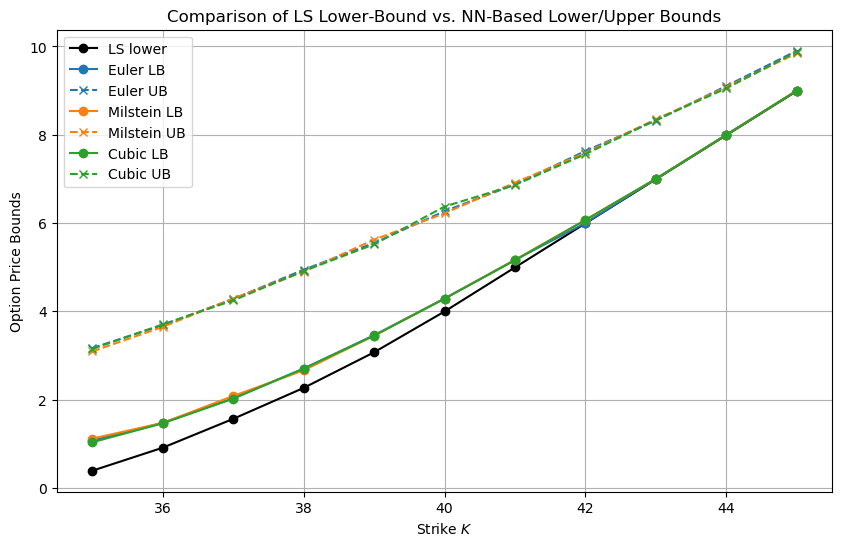

In [ ]:
import matplotlib.pyplot as plt


strikes = list(range(35, 46))

ls_lbs = LBs.numpy()


euler_lbs    = [ results['euler'][K][0]    for K in strikes ]
euler_ubs    = [ results['euler'][K][1]    for K in strikes ]
milstein_lbs = [ results['milstein'][K][0] for K in strikes ]
milstein_ubs = [ results['milstein'][K][1] for K in strikes ]
cubic_lbs    = [ results['cubic'][K][0]    for K in strikes ]
cubic_ubs    = [ results['cubic'][K][1]    for K in strikes ]

plt.figure(figsize=(10,6))


plt.plot(strikes, ls_lbs,    '-k', label='LS lower',   marker='o')


plt.plot(strikes, euler_lbs,    '-C0', label='Euler LB',    marker='o')
plt.plot(strikes, euler_ubs,    '--C0', label='Euler UB',    marker='x')
plt.plot(strikes, milstein_lbs, '-C1', label='Milstein LB', marker='o')
plt.plot(strikes, milstein_ubs, '--C1', label='Milstein UB', marker='x')
plt.plot(strikes, cubic_lbs,    '-C2', label='Cubic LB',    marker='o')
plt.plot(strikes, cubic_ubs,    '--C2', label='Cubic UB',    marker='x')

plt.xlabel('Strike $K$')
plt.ylabel('Option Price Bounds')
plt.title('Comparison of LS Lower‐Bound vs. NN‐Based Lower/Upper Bounds')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()